In [ ]:
# default_exp flow_embedding_training_utils
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import directed_graphs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Visualization Utils for the Flow Embedder

In the quest to have maximum code separation, we're separating the of 05c's flow embedder into separate embedding and visualization schemes.

This notebook will house barebones code to visualize the losses and embedded points of the MFE concurrently with training, as well as tools for saving and creating GIFs from the embedding trainings.

A general philosophy here is to avoid printing ad naseum as much as possible, by compressing the form of information served to the most appropriate condensed form for efficient summarization.

We'll start with the meat and bones of the flow embedder: visualizing the embedded points, with a grid to visualize flow arrows.

In [ ]:
# export
import torch
from directed_graphs.multiscale_flow_embedder import compute_grid
device = torch.device("cuda" if torch.has_cuda else "cpu")
def visualize_points(embedded_points, flow_artist, labels = None, device = device, title = "Flow Embedding", save = False, **kwargs):
		# computes grid around points
		# TODO: This might create CUDA errors
		grid = compute_grid(embedded_points.to(device))
		# controls the x and y axes of the plot
		# linspace(min on axis, max on axis, spacing on plot -- large number = more field arrows)
		uv = flow_artist(grid).detach().cpu()
		u = uv[:,0].cpu()
		v = uv[:,1].cpu()
		x = grid.detach().cpu()[:,0]
		y = grid.detach().cpu()[:,1]
		# quiver 
		# 	plots a 2D field of arrows
		# 	quiver([X, Y], U, V, [C], **kw); 
		# 	X, Y define the arrow locations, U, V define the arrow directions, and C optionally sets the color.
		if labels is not None:
			sc = plt.scatter(embedded_points[:,0].detach().cpu(),embedded_points[:,1].detach().cpu(), c=labels)
			plt.legend()
		else:
			sc = plt.scatter(embedded_points[:,0].detach().cpu(),embedded_points[:,1].detach().cpu())
		plt.suptitle("Flow Embedding")
		plt.quiver(x,y,u,v)
		# Display all open figures.
		if save:
			plt.savefig(f"visualizations/{title}.jpg")
		else:
			plt.show()
		plt.close()

In [ ]:
# export
def save_embedding_visualization(embedded_points, flow_artist, labels = None, device = device, title = "Flow Embedding", **kwargs):
  visualize_points(embedded_points=embedded_points, flow_artist = flow_artist, labels = labels, device = device, title = title, save=True)

In [ ]:
# export
def collate_loss(provided_losses, prior_losses = None, loss_type = "total", ):
		# diffusion_loss,reconstruction_loss, smoothness_loss
		x = []
		k = ""
		if prior_losses is None:
			# if there are no prior losses, initialize a new dictionary to store these
			losses = {}
			for key in provided_losses.keys():
				losses[key] = []
				# k = key
			losses["total"] = []
		for i in range(max(provided_losses["diffusion"], provided_losses["smoothness"],provided_losses["diffusion map regularization"],provided_losses["flow cosine loss"])):
			x.append(i)
			for key in provided_losses.keys():
				try:
					losses[key].append(provided_losses[key][i].detach().cpu().numpy())
				except:
					losses[key].append(0)
		return losses

# Training Scheme

This class will instantiate the Flow Embedder with preset parameters, and will train for a few hundred epochs while calling in these visualization functions, like swappable modules.

The base class will take a list of visualization functions as input, and will iterate over them whenever it is called to visualize.

Subsequent notebooks (05c0n) will inherit from this class.

In [ ]:
# export
import torch.nn as nn
import torch
import time
import datetime
from directed_graphs.multiscale_flow_embedder import MultiscaleDiffusionFlowEmbedder
from tqdm import trange
import glob
from PIL import Image
import os
import ipywidgets as widgets
import base64

class FETrainer(nn.Module):
  def __init__(self, X, flows, labels):
    super(FETrainer, self).__init__()
    self.vizfiz = [
      save_embedding_visualization,
    ]
    self.FE = MultiscaleDiffusionFlowEmbedder(
      X = X,
      flows = flows,
      ts = (1, 2, 4, 8),
      sigma_graph = 0.5,
      flow_strength_graph = 5
    )
    self.losses = None
    self.labels = labels
    self.title = "Vanilla MFE"
    self.epochs_between_visualization = 100
    self.total_epochs = 10000
    self.timestamp = datetime.datetime.now().isoformat()
    os.mkdir(f'visualizations/{self.timestamp}')
  
  def fit(self):
    num_training_runs = self.total_epochs // self.epochs_between_visualization
    for epoch_num in trange(num_training_runs):
      start = time.time()
      emb_X, flow_artist, losses = self.FE.fit(n_steps = self.epochs_between_visualization)
      stop = time.time()
      title = f"{self.timestamp}/{self.title} Epoch {epoch_num}"
      self.visualize(emb_X, flow_artist, losses, title)
      self.losses = collate_loss(provided_losses=losses, prior_losses=self.losses)
    self.embedded_points = emb_X
    self.flow_artist = flow_artist
    self.losses = losses

  def visualize(self, embedded_points, flow_artist, losses, title):
    for viz_f in self.vizfiz:
      viz_f(embedded_points= embedded_points, flow_artist = flow_artist, losses = losses, title = title, labels = labels)
  
  def training_gif(self):
    frames = [Image.open(image) for image in glob.glob(f"visualizations/{self.timestamp}/*.jpg")]
    frame_one = frames[0]
    frame_one.save(f"{self.title}.gif", format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0)
    # display in jupyter notebook
    b64 = base64.b64encode(open(f"{self.title}.gif",'rb').read()).decode('ascii')
    display(widgets.HTML(f'<img src="data:image/gif;base64,{b64}" />'))

  def visualize_embedding(self):
    visualize_points(embedded_points=self.embedded_points, flow_artist = self.flow_artist, labels = self.labels, title = self.title)

  def visualize_loss(self, loss_type="all"):
    if loss_type == "all":
      for key in self.losses.keys():
        plt.plot(self.losses[key])
      plt.legend(self.losses.keys(), loc='upper right')
      plt.title("loss")
    else:
      plt.plot(self.losses[loss_type])
      plt.title(loss_type)


    

# Testing
We'll try this with our old standby test case: the swiss roll. 


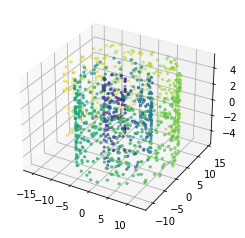

In [ ]:
from directed_graphs.datasets import directed_swiss_roll_uniform, plot_directed_3d
X, flow, labels = directed_swiss_roll_uniform(num_nodes=1000, num_spirals=2.5, radius=1, height=10, xtilt=0, ytilt=0)
plot_directed_3d(X, flow, labels, mask_prob=0.1)
X = torch.tensor(X)
flow = torch.tensor(flow)
X = X.float().to(device)
flow = flow.float().to(device)

In [ ]:
FET = FETrainer(X, flow, labels = labels)

In [ ]:
FET.fit()

  0%|          | 0/100 [03:49<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
FET.training_gif()

HTML(value='<img src="data:image/gif;base64,R0lGODlhsAEgAYcAAP////7///z///v///n///f///T//+b//////f//+/7//P//+v…